# CHECKLIST

<p><input type="checkbox" checked> The kinetics of buffers, pumps and exchangers are more or less accurate and based on the recent literature.</p>
<p><input type="checkbox" checked> PMCA, SERCA, NCX implemented </p>
<p><input type="checkbox" checked> Buffers PV, CaM, CB, CR implemented kinetics and concentrations are based on the recent literature <p/>
<p><input type="checkbox" checked> Immunocytochemistry, immunoreactivity profiles, silver-intensified immunogold method** (Minelli et al., 2006) <p/>

* **разобраться, что такое high d_app Faas et al. 2011 (CaM kinetics)**
* Re-check the concentrations of buffers in axonal boutons
* Density of PMCA pumps in hippocampal presynaptic boutons ???
    * https://www.ncbi.nlm.nih.gov/pmc/articles/PMC2635118/
    * PMCA2a is largely restricted to parvalbumin-positive inhibitory presynaptic terminals throughout the brain (Buretter 2009)
    * PMCA2a staining was mostly restricted to parvalbumin-positive axon terminals
* Density of SERCA pumps in hippocampal presynaptic boutons ???
* Density of NCX antiporters in presynaptic boutons ???
* A more accurate model of NCX1,2,3 that take into accound possible cooperativity between Na+ and Ca2+ binding sites/domains.
* ошибка в рассчёте объёма синапса была связана с тем, что я предполагал, что концентрация в SM дана для всего объёма синапса, а она на самом деле дана только для цитозоля. Так что если накинуть объём vesicles (0.015 $\mu$m * 383), and other organelles, то объём будет приблизительно тот, что нужен (0.37 $\mu$m3 or 3.7 * 10e-19 m3)




In [19]:
# CaM kinetics:
Eggerman2002 = True

In [20]:
import steps.model as smodel
import steps.geom as swm
import steps.rng as srng
import steps.solver as ssolver
import numpy as np
import matplotlib.pyplot as plt
from scipy.constants import N_A
import pandas as pd
import sys


def printProgressBar (iteration, total, prefix = '', suffix = '', decimals = 1, length = 100, fill = '█'):
    percent = ("{0:." + str(decimals) + "f}").format(100 * (iteration / float(total)))
    filledLength = int(length * iteration // total)
    bar = fill * filledLength + '-' * (length - filledLength)
    sys.stdout.write('\r%s |%s| %s%% %s' % (prefix, bar, percent, suffix))
    sys.stdout.flush()
    # Print New Line on Complete
    if iteration == total: 
        print()

# instantiate the model:
mdl = smodel.Model()

# instantiate volume systems (a VS groups together different reaction and diffusion rules):
vsys = smodel.Volsys('vsys', mdl)   # cytosol
vsys1 = smodel.Volsys('vsys1', mdl) # extracellular space

# instantiate surface systems (a SS groups together different reaction and diffusion rules):
surfsys = smodel.Surfsys('ssys', mdl)   # ER membrane
surfsys1 = smodel.Surfsys('ssys1', mdl) # cell membrane

# instantiate key SPECIES:
Ca = smodel.Spec('Ca', mdl)
Na = smodel.Spec('Na', mdl)
ATP  = smodel.Spec('ATP', mdl)
ADP  = smodel.Spec('ADP', mdl)
PMCA = smodel.Spec('PMCA', mdl)

CaInflux = smodel.Reac('CaInflux', vsys, rhs=[Ca], kcst=0)

# Parvalbumin (PV) kinetics and concentration in rat HC boutons


* Kinetics taken from Lee et al. (2000)
* Data for the presence and concentration of PV in rat HC axons taken from Wilhelm et al. (2014).

Wilhelm, B. G., Mandad, S., Truckenbrodt, S., Kroḧnert, K., Schäfer, C., Rammner, B., … Rizzoli, S. O. (2014). Composition of isolated synaptic boutons reveals the amounts of vesicle trafficking proteins. Science. https://doi.org/10.1126/science.1252884

Lee, S. H., Schwaller, B., & Neher, E. (2000). Kinetics of Ca2+ binding to parvalbumin in bovine chromaffin cells: Implications for [Ca2+] transients of neuronal dendrites. Journal of Physiology. https://doi.org/10.1111/j.1469-7793.2000.t01-2-00419.x


In [21]:
PV = smodel.Spec('PV', mdl) 
PV_Ca = smodel.Spec('PV_Ca', mdl)
PV_2Ca = smodel.Spec('PV_2Ca', mdl)

kreac_f_PV_Ca = smodel.Reac('kreac_f_PV_Ca', vsys, lhs=[PV, Ca], rhs=[PV_Ca], kcst=107e6)
kreac_b_PV_Ca = smodel.Reac('kreac_b_PV_Ca', vsys, lhs=[PV_Ca], rhs=[PV, Ca], kcst=0.95)

kreac_f_PV_2Ca = smodel.Reac('kreac_f_PV_2Ca', vsys, lhs=[PV_Ca, Ca], rhs=[PV_2Ca], kcst=107e6)
kreac_b_PV_2Ca = smodel.Reac('kreac_b_PV_2Ca', vsys, lhs=[PV_2Ca], rhs=[PV_Ca, Ca], kcst=0.95)

# Calbindin (CB) kinetics

* CB has four Ca2+ binding sites;
* We consider a configuration with 2 high affinity and 2 low affinity sites
* Kinetics taken from Nägerl et al. (2000)
* Though it seems to be generally accepted that calbindin-D28K (CB) has one very high affinity calcium binding site (Kd •1 nÒ) and two or three lower affinity calcium binding sites (Kd •10 ìÒ) (Gross et al. 1993), the details of the calcium binding properties of CB are not yet known

Nägerl, U. V., Novo, D., Mody, I., & Vergara, J. L. (2000). Binding kinetics of calbindin-D(28k) detemined by flash photolysis of caged Ca2+. Biophysical Journal. https://doi.org/10.1016/S0006-3495(00)76537-4

In [22]:
CBhi = smodel.Spec('CBhi', mdl)         # CALBINDIN 1 (D-28K) (we consider the 2 (hi-aff) : 2 (lo-aff) scenario)
CBhi_Ca = smodel.Spec('CBhi_Ca', mdl)   # Binding Kinetics of Calbindin-D28k Determined by Flash Photolysis of Caged Ca2 (Nägerl 2000)
CBhi_2Ca = smodel.Spec('CBhi_2Ca', mdl)
CBlo = smodel.Spec('CBlo', mdl)
CBlo_Ca = smodel.Spec('CBlo_Ca', mdl)
CBlo_2Ca = smodel.Spec('CBlo_2Ca', mdl)


kreac_f_CBhi_Ca = smodel.Reac('kreac_f_CBhi_Ca', vsys, lhs = [CBhi, Ca], rhs = [CBhi_Ca], kcst = 1.1e7)
kreac_b_CBhi_Ca = smodel.Reac('kreac_b_CBhi_Ca', vsys, lhs = [CBhi_Ca], rhs = [CBhi, Ca], kcst = 2.607)

kreac_f_CBhi_2Ca = smodel.Reac('kreac_f_CBhi_2Ca', vsys, lhs = [CBhi_Ca, Ca], rhs = [CBhi_2Ca], kcst = 1.1e7)
kreac_b_CBhi_2Ca = smodel.Reac('kreac_b_CBhi_2Ca', vsys, lhs = [CBhi_2Ca], rhs = [CBhi_Ca, Ca], kcst = 2.607)

kreac_f_CBlo_Ca = smodel.Reac('kreac_f_CBlo_Ca', vsys, lhs = [CBlo, Ca], rhs = [CBlo_Ca], kcst = 8.7e7)
kreac_b_CBlo_Ca = smodel.Reac('kreac_b_CBlo_Ca', vsys, lhs = [CBlo_Ca], rhs = [CBlo, Ca], kcst = 35.76)

kreac_f_CBlo_2Ca = smodel.Reac('kreac_f_CBlo_2Ca', vsys, lhs = [CBlo_Ca, Ca], rhs = [CBlo_2Ca], kcst = 8.7e7)
kreac_b_CBlo_2Ca = smodel.Reac('kreac_b_CBlo_2Ca', vsys, lhs = [CBlo_2Ca], rhs = [CBlo_Ca, Ca], kcst = 35.76)

# Calmodulin (CaM) kinetics

* CaM has four Ca2+ binding sites - two cooperative pairs;
* We represent cooperative site pairs as separate species;

<img src="images/CR_model.png" alt="Drawing" style="width: 350px;"/>

<img src="images/CaM_kinetics.png" alt="Drawing" style="width: 350px;"/>

Faas, G. C., Raghavachari, S., Lisman, J. E., & Mody, I. (2011). Calmodulin as a direct detector of Ca2+ signals. Nature Neuroscience. https://doi.org/10.1038/nn.2746



In [23]:
CaM_NtNt = smodel.Spec('CaM_NtNt', mdl)
CaM_NtNr = smodel.Spec('CaM_NtNr', mdl)
CaM_NrNr = smodel.Spec('CaM_NrNr', mdl)

CaM_CtCt = smodel.Spec('CaM_CtCt', mdl)
CaM_CtCr = smodel.Spec('CaM_CtCr', mdl)
CaM_CrCr = smodel.Spec('CaM_CrCr', mdl)

if Eggerman2002==True:
    KonT_N  = 7.7e8
    KoffT_N = 1.6e5
    KonR_N  = 3.2e10
    KoffR_N = 2.2e4

    KonT_C  = 8.4e7
    KoffT_C = 2.6e3
    KonR_C  = 2.5e7
    KoffR_C = 6.5
else:
    KonT_N  = 8.9e8
    KoffT_N = 5.2e5
    KonR_N  = 10.5e10
    KoffR_N = 4.3e4

    KonT_C  = 7.9e7
    KoffT_C = 3.4e3
    KonR_C  = 7.4e7
    KoffR_C = 1.2


kreac_f_CaM_NtNt = smodel.Reac('kreac_f_CaM_NtNt', vsys, lhs = [CaM_NtNt, Ca], rhs = [CaM_NtNr], kcst = 2 * KonT_N)
kreac_b_CaM_NtNt = smodel.Reac('kreac_b_CaM_NtNt', vsys, lhs = [CaM_NtNr], rhs = [CaM_NtNt, Ca], kcst = KoffT_N)

kreac_f_CaM_NrNr = smodel.Reac('kreac_f_CaM_NrNr', vsys, lhs = [CaM_NtNr, Ca], rhs = [CaM_NrNr], kcst = KonR_N)
kreac_b_CaM_NrNr = smodel.Reac('kreac_b_CaM_NrNr', vsys, lhs = [CaM_NrNr], rhs = [CaM_NtNr, Ca], kcst = 2 * KoffR_N)

kreac_f_CaM_CtCt = smodel.Reac('kreac_f_CaM_CtCt', vsys, lhs = [CaM_CtCt, Ca], rhs = [CaM_CtCr], kcst = 2 * KonT_C)
kreac_b_CaM_CtCt = smodel.Reac('kreac_b_CaM_CtCt', vsys, lhs = [CaM_CtCr], rhs = [CaM_CtCt, Ca], kcst = KoffT_C)

kreac_f_CaM_CrCr = smodel.Reac('kreac_f_CaM_CrCr', vsys, lhs = [CaM_CtCr, Ca], rhs = [CaM_CrCr], kcst = KonR_C)
kreac_b_CaM_CrCr = smodel.Reac('kreac_b_CaM_CrCr', vsys, lhs = [CaM_CrCr], rhs = [CaM_CtCr, Ca], kcst = 2 * KoffR_C)

# Calretinin (CR) kinetics

<img src="images/CR_model.png" alt="Drawing" style="width: 350px;"/>
<img src="images/CR_main.png" alt="Drawing" style="width: 350px;"/>
<img src="images/ind_site.png" alt="Drawing" style="width: 350px;"/>

* CALRETININ (CALBINDIN 2) HAS 6 EF-hand motifs, 5 of which can bind Ca.
* Sites 1 and 2 form a cooperative pair, as do sites 3 and 4. Site 5 is an independent Ca-binding site.
* a binding site is in the T state when the other binding site has no Ca2+ bound
* SINCE CR HAS 5 DOMAINS (TWO PAIRS OF COOPERATIVE ONES AND ONE INDEPENDENT DOMAIN) WE REPRESENT CR AS TWO COPIES OF THE SAME SPECIES (EACH CARRYING ONE PAIR OF COOPERATIVE BINDING SITES)

Faas, G. C., Schwaller, B., Vergara, J. L., & Mody, I. (2007). Resolving the fast kinetics of cooperative binding: Ca2+ buffering by calretinin. PLoS Biology. https://doi.org/10.1371/journal.pbio.0050311

In [24]:
CRTT     = smodel.Spec('CRTT', mdl)     # pairs of cooperative binding sites MULTIPLY BY TWO to get 4
CRTR_Ca  = smodel.Spec('CRTR_Ca', mdl)
CRRR_2Ca = smodel.Spec('CRRR_2Ca', mdl)
CRind     = smodel.Spec('CRind', mdl)
CRind_Ca  = smodel.Spec('CRind_Ca', mdl) # independent binding site

kon_T  = 1.8e6
koff_T = 53
kon_R  = 3.1e8
koff_R = 20
kon_ind  = 7.3e6
koff_ind = 252

# pair 1 (you MUST multiply its concentration by 2) because WE'VE GOT TWO PAIRS OF COOPERATIVE CA2+ BINDING SITES
kreac_f_CRTT1_Ca = smodel.Reac('kreac_f_CRTT1_Ca', vsys, lhs = [CRTT, Ca], rhs = [CRTR_Ca], kcst=2*kon_T) # two domains are free, so we multiply the association rate by 2
kreac_b_CRTT1_Ca = smodel.Reac('kreac_b_CRTT1_Ca', vsys, lhs = [CRTR_Ca], rhs = [CRTT, Ca], kcst=koff_T)
kreac_f_CRRR1_2Ca = smodel.Reac('kreac_f_CRRR1_2Ca', vsys, lhs = [CRTR_Ca, Ca], rhs = [CRRR_2Ca], kcst=kon_T) 
kreac_b_CRRR1_2Ca = smodel.Reac('kreac_b_CRRR1_2Ca', vsys, lhs = [CRRR_2Ca], rhs = [CRTR_Ca, Ca], kcst = 2*koff_R) # two domains are occupied, so we multiply the dissociation rate by 2

# independent Ca2+ binding site:
kreac_f_CRind_Ca = smodel.Reac('kreac_f_CRind_Ca', vsys, lhs = [CRind, Ca], rhs = [CRind_Ca], kcst=kon_ind)
kreac_b_CRind_Ca = smodel.Reac('kreac_b_CRind_Ca', vsys, lhs = [CRind_Ca], rhs = [CRind, Ca], kcst=koff_ind)

## SERCA kinetics

* SERCA kinetics data is taken from Bartol et al. (2015).
<img src="images/SERCA_kinetics.png" alt="Drawing" style="width: 250px;"/>

Bartol, T. M., Keller, D. X., Kinney, J. P., Bajaj, C. L., Harris, K. M., Sejnowski, T. J., & Kennedy, M. B. (2015). Computational reconstitution of spine calcium transients from individual proteins. Frontiers in Synaptic Neuroscience. https://doi.org/10.3389/fnsyn.2015.00017

In [25]:
# SERCA species:
SERCA_X0Ca = smodel.Spec('SERCA_X0Ca', mdl)
SERCA_X1Ca = smodel.Spec('SERCA_X1Ca', mdl)
SERCA_X2Ca = smodel.Spec('SERCA_X2Ca', mdl)
SERCA_Y2Ca = smodel.Spec('SERCA_Y2Ca', mdl)
SERCA_Y1Ca = smodel.Spec('SERCA_Y1Ca', mdl)
SERCA_Y0Ca = smodel.Spec('SERCA_Y0Ca', mdl)

# on- and off-rates for SERCA:
kx0x1 = 2e8
kx1x0 = 83.7 
kx1x2 = 1e8 
kx2x1 = 167.4
kx2y2 = 0.6
ky2x2 = 0.097
ky2y1 = 60.04
ky1y2 = 60e-6 * 1e5
ky1y0 = 30.02
ky0y1 = 60e-6 * 2e5
ky0x0 = 0.4
kx0y0 = 1.2e-3


# Reactions involving SERCA:

# when SERCA faces outward (into the cytosol):
ser_x0x1 = smodel.SReac('ser_x0x1', surfsys, olhs=[Ca], slhs=[SERCA_X0Ca], srhs=[SERCA_X1Ca], kcst=kx0x1)
ser_x1x0 = smodel.SReac('ser_x1x0', surfsys, slhs=[SERCA_X1Ca], olhs=[Ca], srhs=[SERCA_X0Ca], kcst=kx1x0)
ser_x1x2 = smodel.SReac('ser_x1x2', surfsys, olhs=[Ca], slhs=[SERCA_X1Ca], srhs=[SERCA_X2Ca], kcst=kx1x2)
ser_x2x1 = smodel.SReac('ser_x2x1', surfsys, slhs=[SERCA_X2Ca], olhs=[Ca], srhs=[SERCA_X1Ca], kcst=kx2x1)

# we change conformation from inward-facing to outward-facing:
ser_x2y2 = smodel.SReac('ser_x2y2', surfsys, slhs=[SERCA_X2Ca], srhs=[SERCA_Y2Ca],            kcst=kx2y2)
ser_y2x2 = smodel.SReac('ser_y2x2', surfsys, slhs=[SERCA_Y2Ca], srhs=[SERCA_X2Ca],            kcst=ky2x2)

# when SERCA faces inward (into the ER):
ser_y2y1 = smodel.SReac('ser_y2y1', surfsys, slhs=[SERCA_Y2Ca], srhs=[SERCA_Y1Ca], irhs=[Ca], kcst=ky2y1)
ser_y1y2 = smodel.SReac('ser_y1y2', surfsys, ilhs=[Ca], slhs=[SERCA_Y1Ca], srhs=[SERCA_Y2Ca], kcst=ky1y2)
ser_y1y0 = smodel.SReac('ser_y1y0', surfsys, slhs=[SERCA_Y1Ca], srhs=[SERCA_Y0Ca], irhs=[Ca], kcst=ky1y0)
ser_y0y1 = smodel.SReac('ser_y0y1', surfsys, ilhs=[Ca], slhs=[SERCA_Y0Ca], srhs=[SERCA_Y1Ca], kcst=ky0y1)

# we change conformation from outward-facing to inward-facing:
ser_y0x0 = smodel.SReac('ser_y0x0', surfsys, slhs=[SERCA_Y0Ca], srhs=[SERCA_X0Ca]           , kcst=ky0x0)
ser_x0y0 = smodel.SReac('ser_x0y0', surfsys, slhs=[SERCA_X0Ca], srhs=[SERCA_Y0Ca]           , kcst=kx0y0)


# https://www.jneurosci.org/content/25/4/950/tab-figures-data
# SERCA_Ca_flux = smodel.SReac('SERCA_Ca_flux', surfsys, olhs=[ATP, Ca], slhs=[SERCA], srhs=[SERCA], irhs=[Ca], orhs=[ADP], kcst=17147e6)

## **NCX kinetics**
The literature is unclear about the exact kinetics of Na$^{+}$ association to and dissociation from NCX and whether there is any cooperativity between Na$^{+}$-binding sites and Ca$^{2+}$-binding sites.

There is 'Na inactivation', and I did not fully understand how it could be incorporated into the model.


* According to Giladi et al. (2000), NCX1 consists of two CBDs (HA and LA). CBD1 binds 2 calciums, CBD2 1 calcium

<img src="images/NCX_kinetics.png" alt="Drawing" style="width: 550px;"/>

* NCX can extrude one Ca in exchange for three Na+
* Exactly how this occurs is not yet understood
* In our model we DISREGARD Na+, and use a simplified NCX model as described by Bartol et al. (2015).
* The **leak** is a 1st order reaction. I am not sure how to implement it based on the diagram. I assumed that P0 can 'catch' one calcium and immediately transport it into the membrane at a rate of k_leak.
* There is a paper that used silver-enhanced immunogold procedure to label NCX1, NCX2 and NCX3. The short story is that NCX is predominantly expressed everywhere but not axonal terminals. Although the paper lists relative counts (percentages of immunolabeled ultrathin sections of tissue, we roughly estimated the density of NCX1 in axonal terminals to be 6.26 $\mu$m$^{-2}$, which is about 23 times lower than in spines.

$$
\frac{N_{den}}{N_{ax}} \approx \frac{D_{den}}{D_{ax}}
$$
where $D_{den}$ = 143 $\mu m^{-2}$ (Bartol et al. 2015), $N_{den} = 868 $ and $N_{ax} = 38$ (Minelli et al. 2007)



<img src="images/NCX_kinetics2.png" alt="Drawing" style="width: 550px;"/><img src="images/NCX_kinetics1.png" alt="Drawing" style="width: 250px;"/>

Bartol, T. M., Keller, D. X., Kinney, J. P., Bajaj, C. L., Harris, K. M., Sejnowski, T. J., & Kennedy, M. B. (2015). Computational reconstitution of spine calcium transients from individual proteins. Frontiers in Synaptic Neuroscience. https://doi.org/10.3389/fnsyn.2015.00017

Giladi, M., Boyman, L., Mikhasenko, H., Hiller, R., & Khananshvili, D. (2010). Essential role of the CBD1-CBD2 linker in slow dissociation of Ca 2+ from the regulatory two-domain tandem of NCX1. Journal of Biological Chemistry. https://doi.org/10.1074/jbc.M110.127001

In [26]:
# NCX species:
NCX_P0 = smodel.Spec('NCX_P0', mdl)
NCX_P1 = smodel.Spec('NCX_P1', mdl)

k1_ncx = 3e8
k2_ncx = 300
k3_ncx = 600
kl_ncx = 19.4


NCX_P0P1 = smodel.SReac('NCX_P0P1', surfsys1, ilhs=[Ca], slhs=[NCX_P0], srhs=[NCX_P1], kcst=k1_ncx)
NCX_P1P0 = smodel.SReac('NCX_P1P0', surfsys1, slhs=[NCX_P1], srhs=[NCX_P0], ilhs=[Ca], kcst=k2_ncx)
NCX_P1P0ext = smodel.SReac('NCX_P1P0ext', surfsys1, slhs=[NCX_P1], srhs=[NCX_P0], orhs=[Ca], kcst=k3_ncx)
NCX_leak = smodel.SReac('NCX_leak', surfsys1, slhs=[NCX_P0], olhs=[Ca], srhs=[NCX_P0], orhs=[Ca], kcst=kl_ncx)

# PMCA kinetics
* In presynapses (not necessarily of hippocampal pyramidal neurons), mostly PMCA3 isoform is expressed (Brini et al. 2013).
* The model does not depend on ATP and assumes constant ATP availability

* In our model we DISREGARD ATP (it is assumed to be constant), and use a simplified PMCA model as described by Bartol et al. (2015).
* The **leak** is a 1st order reaction. I am not sure how to implement it based on the diagram. I assumed that P0 can 'catch' one calcium and immediately transport it into the membrane at a rate of k_leak.
* No direct PMCA density data is available for axonal boutons, so we <span style="color:red">**assumed**</span> the same density as in dendritic spines: 488 $\mu$m$^{2}$. Thus, given the cell membrance area, the absolute PMCA pump count works out to be 828


<img src="images/NCX_kinetics2.png" alt="Drawing" style="width: 550px;"/><img src="images/NCX_kinetics1.png" alt="Drawing" style="width: 250px;"/>

Brini, M., & Carafoli, E. (2011). The Plasma Membrane Ca2+ ATPase and the plasma membrane Sodium Calcium exchanger cooperate in the regulation of cell Calcium. Cold Spring Harbor Perspectives in Biology. https://doi.org/10.1101/cshperspect.a004168

In [27]:
# PMCA species:
PMCA_P0 = smodel.Spec('PMCA_P0', mdl)
PMCA_P1 = smodel.Spec('PMCA_P1', mdl)

k1_pmca = 1.5e8
k2_pmca = 15
k3_pmca = 12
kl_pmca = 4.3


PMCA_P0P1 = smodel.SReac('PMCA_P0P1', surfsys1, ilhs=[Ca], slhs=[PMCA_P0], srhs=[PMCA_P1], kcst=k1_pmca)
PMCA_P1P0 = smodel.SReac('PMCA_P1P0', surfsys1, slhs=[PMCA_P1], srhs=[PMCA_P0], ilhs=[Ca], kcst=k2_pmca)
PMCA_P1P0ext = smodel.SReac('PMCA_P1P0ext', surfsys1, slhs=[PMCA_P1], srhs=[PMCA_P0], orhs=[Ca], kcst=k3_pmca)
PMCA_leak = smodel.SReac('PMCA_leak', surfsys1, slhs=[PMCA_P0], olhs=[Ca], srhs=[PMCA_P0], orhs=[Ca], kcst=kl_pmca)

# CaRemPMCA = smodel.SReac('CaRemPMCA', surfsys1, ilhs=[ATP, Ca], slhs=[PMCA], srhs=[PMCA], orhs=[Ca], irhs=[ADP], kcst=25000e6)

In [28]:
r, h = 0.3, 0.6
2*(np.pi * r**2) + 2*np.pi*r*h

1.6964600329384885

# Presynaptic bouton volume, membrane surface area and ER membrane surface area 
* In principle its size should be comparable to that of a dendritic spine.
* Sammons et al. 2017 report bouton sizes (in L2/3 of mouse visual cortex) in 'normalized axonal backbone units' that I could not convert to cubic meters.
*  Hara et al. (2011) reports axonal terminal volume of 0.142 $\mu$m$^{3}$, although not for pyramidal neurons, but for the outer molecular layer of the dentate gyrus.
* Mishchenko et al. (2010) reports axonal diameter of 0.20 $\mu$m (rat CA1 _stratum radiatum_ axons). Using this number and assuming the diameter and length of an _en passant_ presynaptic bouton to be 3 times that of an axon, we can roughly estimate a presynaptic bouton's volume, like so: $V = \pi \Big( \frac {d}{2} \Big)^2 l \approx 0.17$ $\mu$m$^{3}$ which, again roughly, consistent with data reported in Hara et al. (2011).
* We will <span style="color:red">**assume**</span> the cytosol volume to be 3/4 of the entire bouton volume, i.e. 0.1275 $\mu$m$^{3}$

<img src="images/enpassant.png" alt="Drawing" style="width: 350px;"/>

* Given the dimensions of the presynaptic bouton assumed, the membrane surface is the surface area of the cylinder with a radius of 0.3 and height of 0.6 $\mu$m, which is 1.696 $\mu$m$^2$
* Given this area and the density of NCX antiporters, we can calculate their absolute number in the membrane:
$$
1.696 * 6.26 \approx 11
$$


Hara, Y., Park, C. S., Janssen, W. G. M., Punsoni, M., Rapp, P. R., & Morrison, J. H. (2011). Synaptic characteristics of dentate gyrus axonal boutons and their relationships with aging, menopause, and memory in female rhesus monkeys. Journal of Neuroscience. https://doi.org/10.1523/JNEUROSCI.0822-11.2011

Mishchenko, Y., Hu, T., Spacek, J., Mendenhall, J., Harris, K. M., & Chklovskii, D. B. (2010). Ultrastructural analysis of hippocampal neuropil from the connectomics perspective. Neuron. https://doi.org/10.1016/j.neuron.2010.08.014

Sammons, R. P., Clopath, C., & Barnes, S. J. (2018). Size-Dependent Axonal Bouton Dynamics following Visual Deprivation In Vivo. Cell Reports. https://doi.org/10.1016/j.celrep.2017.12.065



# Endoplasmic Reticulum

* We have not found any data on the concentration of SERCA pumps on the ER membrane in axons. 
* So we <span style="color:red">**assumed**</span> the same density as in the ER of dentritic spines: 1000 $\mu$m$^{-2}$ (see _Bartol et al., 2015)_.
* <span style="color:red">**Assuming**</span> this density and the surface area of the ER to be **twice** that of the cell's membrane (2 * 1.696 = 3.392 $\mu$m$^{2}$), the absolute count of the SERCA pumps on the ER membrane works out to be 3392.
* We <span style="color:red">**assumed**</span> the ER volume to be 1/4 of the bouton's entire volume, i.e. 0.0425 $\mu$m$^3$

In [29]:
cytosol_vol = 0.1275e-18
ER_vol = 0.0425e-18
ERmemb_area = 3.392e-12
cellmemb_area = 1.696e-12
extracell_vol = 0.37e-18


# instantiate a 'hub' in which comparments and patches will be instantiated:
wmgeom = swm.Geom()

# create a 'cytosol' compartment:
cytosol = swm.Comp('cytosol', wmgeom, vol=cytosol_vol)

# create the Endoplasmic Reticulum compartment
ER = swm.Comp('ER', wmgeom, vol=ER_vol)  # set arbitrarily to a quarter of the entire synapse volume

# ER is the 'inner' compartment, cytosol is the 'outer' compartment
ERmemb = swm.Patch('ERmemb', wmgeom, ER, cytosol)
ERmemb.addSurfsys('ssys')
ERmemb.setArea(ERmemb_area) # assumed

# put a previously defined volume system into the compartment and set the volume value:
cytosol.addVolsys('vsys')

# cell membrane:
extracell = swm.Comp('extracell', wmgeom, vol=extracell_vol) # The volume here is inconsequential, becuase nothing happens there
cellmemb = swm.Patch('cellmemb', wmgeom, cytosol, extracell)
cellmemb.addSurfsys('ssys1')
cellmemb.setArea(cellmemb_area)

r = srng.create('mt19937', 256)
r.initialize(23412)

# instantiate a solver:
sim = ssolver.Wmdirect(mdl, wmgeom, r)

In [30]:
# reset the solver:
sim.reset()

# set initial conditions (concentration, mohl/L):
def set_init_cond(sim):

    sim.setCompConc('cytosol', 'Ca', 1.6e-6)    # here I was aiming at ~24 ions in the entire volume of the synapse
#     sim.setCompConc('extracell', 'Na', 1.6e-6)    # here I was aiming at ~24 ions in the entire volume of the synapse
    
    # total CB in rat HC: 1.98e-6
    sim.setCompConc('cytosol', 'CBhi', 0.99e-6) # i.e. 1/2 of total CB molarity (1.98*10e-6)
    sim.setCompConc('cytosol', 'CBlo', 0.99e-6) # i.e. 1/2 of total CB molarity (1.98*10e-6)

    # total CaM in rat HC: 57.82e-6
    sim.setCompConc('cytosol', 'CaM_NtNt', 0.5 * 57.82e-6) # i.e. 1/2 of total CaM molarity
    sim.setCompConc('cytosol', 'CaM_CtCt', 0.5 * 57.82e-6) # i.e. 1/2 of total CaM molarity

    
    # total CR in rat HC: 2.47e-6
    # WE MODEL TWO IDENTICAL PAIRS OF COOPERATIVE BINDING SITES AS ONE SPECIES.
    # SO WE SET ITS CONCENTRATION TO 4/5 OF THE TOTAL CONCENTRATION OF CR. THE REMAINING 1/5 IS THE INDEPENDENT SITE/
    sim.setCompConc('cytosol', 'CRTT', 0.1976e-6)   # 4/5 of total CR concentration (2 pairs of cooperative sites)
    sim.setCompConc('cytosol', 'CRind', 0.494e-6)  # 1/5 of total CR
    
    # total PV in rat HC: 4.55e-6
    sim.setCompConc('cytosol', 'PV', 4.55e-6)

    sim.setPatchCount('ERmemb', 'SERCA_X0Ca', 3400)
    sim.setPatchCount('cellmemb', 'PMCA_P0', 828)
    sim.setPatchCount('cellmemb', 'NCX_P0', 11)
    return sim
sim = set_init_cond(sim)

In [31]:
comp_names = [sim.getCompName(i).decode('utf8') for i in range(sim.getNComps())]
patch_names = [wmgeom.getAllPatches()[i].getID() for i in range(len(wmgeom.getAllPatches()))]
print('Comp_names: {}\nPatch_names: {}'.format(comp_names, patch_names))

a = {}
typ = []
gID = []
c = 0
for comp_idx, comp_name in enumerate(comp_names):
    specs = [sim.getCompSpecName(comp_idx, i).decode('utf8') for i in range(sim.getNCompSpecs(comp_idx))]
    a[comp_name] = specs
    typ.append('comp')
    for spec_idx, spec_name in enumerate(specs):
#         print('{}\t{}\t{}\t{}\t{}\t{}'.format(c, comp_idx, comp_name, spec_idx, spec_name, sim.getCompCount(comp_name, spec_name)))
        gID.append([c, comp_idx, comp_name, spec_idx, spec_name])
        c += 1
        
for patch_idx, patch_name in enumerate(patch_names):
    specs = [sim.getPatchSpecName(patch_idx, i).decode('utf8') for i in range(sim.getNPatchSpecs(patch_idx))]
    a[patch_name] = specs
    typ.append('patch')
    for spec_idx, spec_name in enumerate(specs):
#         print('{}\t{}\t{}\t{}\t{}\t{}'.format(c, patch_idx, patch_name, patch_idx, spec_name, sim.getPatchCount(patch_name, spec_name)))
        gID.append([c, patch_idx, patch_name, patch_idx, spec_name])
        c += 1

Comp_names: ['ER', 'cytosol', 'extracell']
Patch_names: ['ERmemb', 'cellmemb']


In [32]:
gID

[[0, 0, 'ER', 0, 'Ca'],
 [1, 1, 'cytosol', 0, 'Ca'],
 [2, 1, 'cytosol', 1, 'CBhi_2Ca'],
 [3, 1, 'cytosol', 2, 'CBhi_Ca'],
 [4, 1, 'cytosol', 3, 'CBhi'],
 [5, 1, 'cytosol', 4, 'CBlo_2Ca'],
 [6, 1, 'cytosol', 5, 'CBlo_Ca'],
 [7, 1, 'cytosol', 6, 'CBlo'],
 [8, 1, 'cytosol', 7, 'CRRR_2Ca'],
 [9, 1, 'cytosol', 8, 'CRTR_Ca'],
 [10, 1, 'cytosol', 9, 'CRTT'],
 [11, 1, 'cytosol', 10, 'CRind'],
 [12, 1, 'cytosol', 11, 'CRind_Ca'],
 [13, 1, 'cytosol', 12, 'CaM_CrCr'],
 [14, 1, 'cytosol', 13, 'CaM_CtCr'],
 [15, 1, 'cytosol', 14, 'CaM_CtCt'],
 [16, 1, 'cytosol', 15, 'CaM_NrNr'],
 [17, 1, 'cytosol', 16, 'CaM_NtNr'],
 [18, 1, 'cytosol', 17, 'CaM_NtNt'],
 [19, 1, 'cytosol', 18, 'PV_2Ca'],
 [20, 1, 'cytosol', 19, 'PV_Ca'],
 [21, 1, 'cytosol', 20, 'PV'],
 [22, 2, 'extracell', 0, 'Ca'],
 [23, 0, 'ERmemb', 0, 'SERCA_X0Ca'],
 [24, 0, 'ERmemb', 0, 'SERCA_X1Ca'],
 [25, 0, 'ERmemb', 0, 'SERCA_Y0Ca'],
 [26, 0, 'ERmemb', 0, 'SERCA_X2Ca'],
 [27, 0, 'ERmemb', 0, 'SERCA_Y2Ca'],
 [28, 0, 'ERmemb', 0, 'SERCA_Y1Ca'],

In [33]:
T = 0.04         # sim time
dt = 0.0001      # delta t
Tp = T/4         # This is when we open Ca2+ channels

# simulate for NITER times every timestep (to smooth out the jitter):
NITER = 30

time = np.arange(0, T, dt)
output = np.zeros((NITER, len(time), len(gID)))

# initialize a progressbar:
pbarlen = 50
printProgressBar(0, NITER, prefix = 'Progress:', suffix = 'Complete', length = pbarlen)

def myround(x, base=dt):
    return base * round(x/base)

for i in range(0, NITER):
    sim.reset()
    sim = set_init_cond(sim)
    c = 0
    for t in np.arange(0, T, dt):
        sim.run(t)
        if t == myround(Tp, base=dt):
            sim.setCompReacK('cytosol','CaInflux', 6.15134760106791e-3)
        if t == myround(Tp, base=dt)+0.0025:
            sim.setCompReacK('cytosol','CaInflux', 0)
        
        ID = 0
        for compORpatch, ty in zip([*a], typ):
            for spec_name in a[compORpatch]:
                if ty=='comp':
                    output[i, c, ID] = sim.getCompCount(compORpatch, spec_name)
                if ty=='patch':
                    output[i, c, ID] = sim.getPatchCount(compORpatch, spec_name)
                ID += 1
        c += 1
    
    # update progress bar:
    printProgressBar(i + 1, NITER, prefix='Progress:', suffix='Complete', length=pbarlen)

Progress: |██████████████████████████████████████████████████| 100.0% Complete


Text(0.5, 1.0, 'NCX')

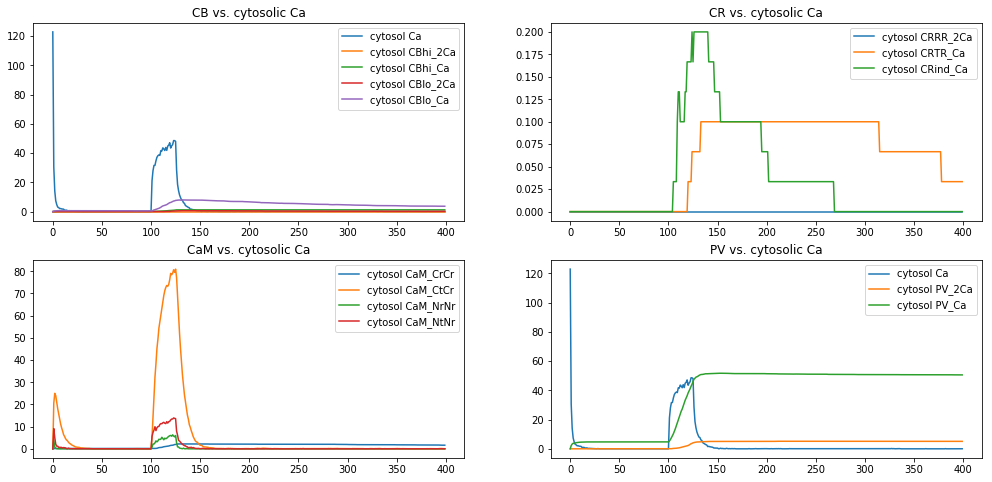

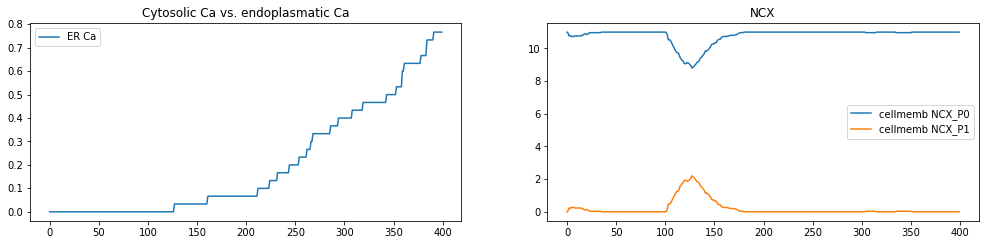

In [34]:
def plot_c(spec_gID):
    for i in spec_gID:
        label = gID[i][2] +' ' + gID[i][4]
        out = np.mean(output[:,:,i], axis=0)
        plt.plot(out, label=label)
    plt.legend()

plt.figure(figsize=(17,8))

plt.subplot(2,2,1)
plot_c([1,2,3,5,6])
plt.title('CB vs. cytosolic Ca')

plt.subplot(2,2,2)
plot_c([8,9,12])
plt.title('CR vs. cytosolic Ca')

plt.subplot(2,2,3)
plot_c([13,14,16,17])
plt.title('CaM vs. cytosolic Ca')

plt.subplot(2,2,4)
plot_c([1,19,20])
plt.title('PV vs. cytosolic Ca')


plt.figure(figsize=(17,8))
plt.subplot(2,2,1)
plot_c([0])
plt.title('Cytosolic Ca vs. endoplasmatic Ca')

plt.subplot(2,2,2)
plot_c([29, 30])
plt.title('NCX')


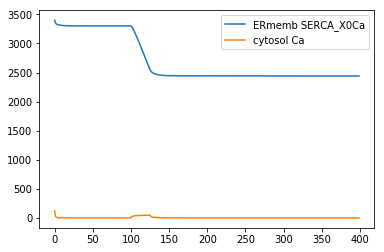

In [35]:
plot_c([23, 1])

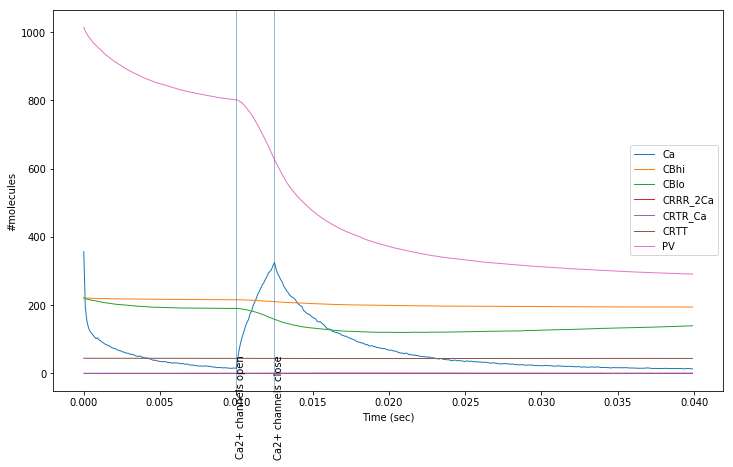

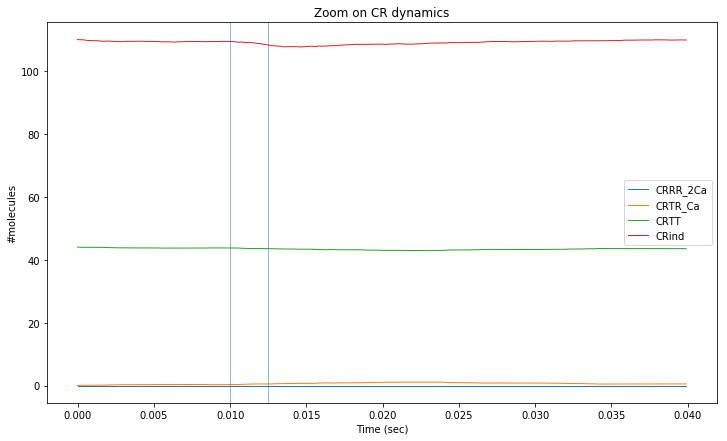

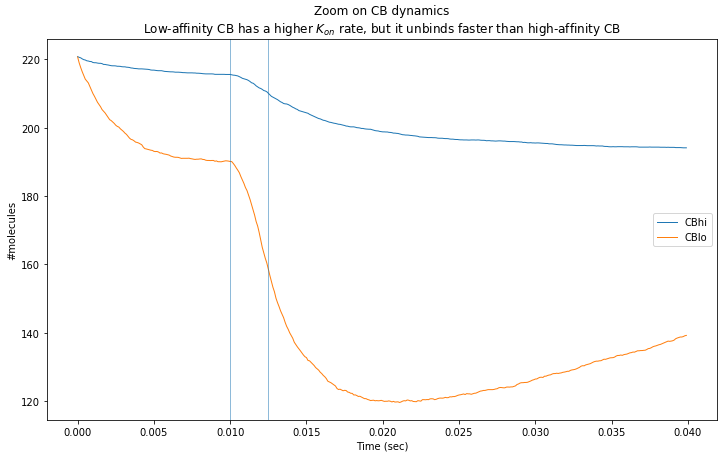

In [57]:
%matplotlib inline
comp_id = 1
#########################################################################################################################
plt.figure(figsize=(12,7))
highlight = ['Ca', 'CRTT', 'CRTR_Ca', 'CRRR_2Ca', 'CBlo', 'CBhi', 'PV']
for j in range(sim.getNCompSpecs(comp_id)):
    spec_name = sim.getCompSpecName(comp_id, j).decode("utf-8")
    string = sim.getCompSpecName(comp_id, j).decode('utf8')
    linewidth = 2 if any([spec_name==i for i in highlight]) else 1
    linewidth = 3 if any([spec_name=='Ca']) else linewidth
    if any([string==i for i in highlight]):
        plt.plot(time, out_mean[:,j], label = string, linewidth=1)
        
plt.axvline(x=Tp, linewidth=0.5)
plt.text(Tp,30,'Ca2+ channels open',rotation=90)

plt.axvline(x=0.0125, linewidth=0.5)
plt.text(0.0125,30,'Ca2+ channels close',rotation=90)
plt.xlabel('Time (sec)')
plt.ylabel('#molecules')
plt.legend(loc='right')
plt.show()

#########################################################################################################################
plt.figure(figsize=(12,7))
plt.title('Zoom on CR dynamics')
highlight = ['CRTT', 'CRTR_Ca', 'CRRR_2Ca', 'CRind']
for j in range(sim.getNCompSpecs(comp_id)):
    string = sim.getCompSpecName(comp_id, j).decode('utf8')
    if any([string==i for i in highlight]):
        plt.plot(time, out_mean[:,j], label = string, linewidth=1)

plt.axvline(x=Tp, linewidth=0.5)
# plt.text(Tp,8,'Ca2+ channels open',rotation=90)
plt.axvline(x=0.0125, linewidth=0.5)
# plt.text(0.0125,8,'Ca2+ channels close',rotation=90)
plt.xlabel('Time (sec)')
plt.ylabel('#molecules')
plt.legend(loc='right')
plt.show()

#########################################################################################################################
plt.figure(figsize=(12,7))
plt.title('Zoom on CB dynamics\n' + 'Low-affinity CB has a higher $K_{on}$ rate, but it unbinds faster than high-affinity CB')
highlight = ['CBlo', 'CBhi']
for j in range(sim.getNCompSpecs(comp_id)):
    spec_name = sim.getCompSpecName(comp_id, j).decode("utf-8")
    linewidth = 2 if any([spec_name==i for i in highlight]) else 1
    linewidth = 3 if any([spec_name=='Ca']) else linewidth
    if any([spec_name==i for i in highlight]):
        plt.plot(time, out_mean[:,j], label = spec_name, linewidth=1)
        
plt.axvline(x=Tp, linewidth=0.5)
# plt.text(Tp,8,'Ca2+ channels open',rotation=90)
plt.axvline(x=0.0125, linewidth=0.5)
# plt.text(0.0125,8,'Ca2+ channels close',rotation=90)
plt.xlabel('Time (sec)')
plt.ylabel('#molecules')
plt.legend(loc='right')
plt.show()


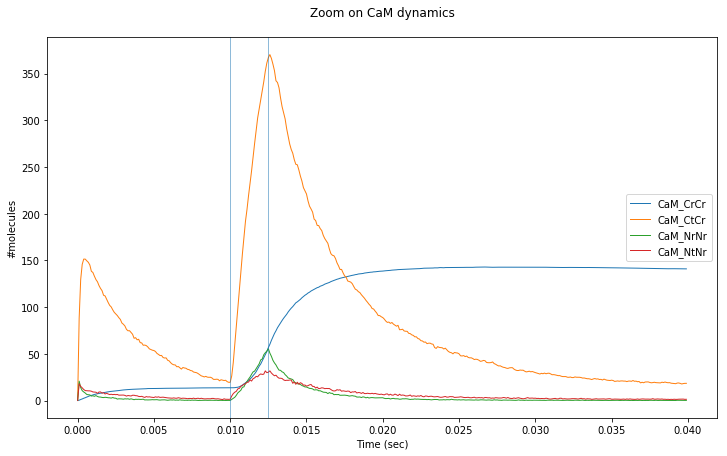

In [58]:

#########################################################################################################################
plt.figure(figsize=(12,7))
plt.title('Zoom on CaM dynamics\n')
# highlight = ['CaM_NtNt', 'CaM_NtNr', 'CaM_NrNr', 'CaM_CtCt', 'CaM_CtCr', 'CaM_CrCr']
highlight = ['CaM_NtNr', 'CaM_NrNr', 'CaM_CtCr', 'CaM_CrCr']
for j in range(sim.getNCompSpecs(comp_id)):
    string = sim.getCompSpecName(comp_id, j).decode('utf8')
    if any([string==i for i in highlight]):
        plt.plot(time, out_mean[:,j], label = string, linewidth=1)

plt.axvline(x=Tp, linewidth=0.5)
# plt.text(Tp,8,'Ca2+ channels open',rotation=90)
plt.axvline(x=0.0125, linewidth=0.5)
# plt.text(0.0125,8,'Ca2+ channels close',rotation=90)
plt.xlabel('Time (sec)')
plt.ylabel('#molecules')
plt.legend(loc='right')
plt.show()

NCX
NCX_Ca_3Na
NCX_Ca
NCX_Ca_1Na
NCX_Ca_2Na


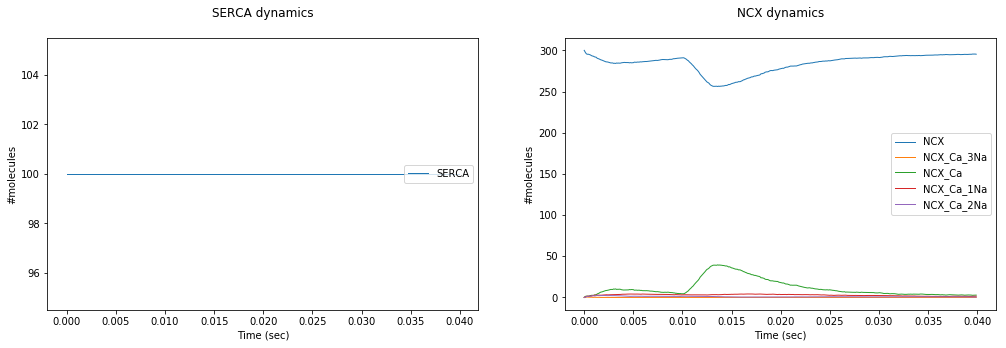

In [59]:
#########################################################################################################################
patch_id = 1
plt.figure(figsize=(17,5))
plt.subplot(1,2,1)
plt.title('SERCA dynamics\n')
highlight = ['SERCA']
for j in range(sim.getNPatchSpecs(patch_id)):
    string = sim.getPatchSpecName(patch_id, j).decode('utf8')
    if any([string==i for i in highlight]):
        plt.plot(time, out_mean2[:,j], label = string, linewidth=1)

plt.xlabel('Time (sec)')
plt.ylabel('#molecules')
plt.legend(loc='right')

#########################################################################################################################

patch_id = 0
plt.subplot(1,2,2)
plt.title('NCX dynamics\n')
highlight = ['NCX', 'NCX_Ca', 'NCX_Ca_1Na', 'NCX_Ca_2Na', 'NCX_Ca_3Na']
for j in range(sim.getNPatchSpecs(patch_id)):
    string = sim.getPatchSpecName(patch_id, j).decode('utf8')
    if any([string==i for i in highlight]):
        print(string)
        plt.plot(time, out_mean4[:,j], label = string, linewidth=1)

plt.xlabel('Time (sec)')
plt.ylabel('#molecules')
plt.legend(loc='right')



In [60]:
[sim.getPatchSpecName(0, j).decode('utf8') for j in range(6)]

['NCX', 'NCX_Ca_3Na', 'PMCA', 'NCX_Ca', 'NCX_Ca_1Na', 'NCX_Ca_2Na']

In [61]:
sim.getPatchCount('cellmemb','NCX_Ca_1Na')

0.0

In [65]:

plt.figure(figsize=(17,7))
plt.subplot(1,2,1)
plt.plot(time, Ca_in_ER, label = 'Ca in ER', linewidth=1)
plt.plot(time, out_mean3[:,j], label = 'Ca in extracell. sp.', linewidth=1)
plt.axvline(x=Tp, linewidth=0.5)
plt.axvline(x=0.0125, linewidth=0.5)
plt.xlabel('Time (sec)')
plt.ylabel('#molecules')
plt.legend(loc='right')

plt.subplot(1,2,2)
plt.plot(time, out_mean[:,22], label='ATP')
plt.axvline(x=Tp, linewidth=0.5)
plt.axvline(x=0.0125, linewidth=0.5)
plt.xlabel('Time (sec)')
plt.ylabel('#molecules')
plt.legend(loc='right')

SyntaxError: invalid syntax (<ipython-input-65-24d57ded845f>, line 1)

In [64]:
out_mean1.shape

(400, 1)

## Comp stats:

In [63]:
comp_name = 'ER' #'extracell'
spec = 'Ca' #'Na'
ncomps = sim.getNComps()
compnames = [sim.getCompName(i).decode('utf8') for i in range(ncomps)]
comp_id = compnames.index(comp_name)
nspecs = sim.getNCompSpecs(comp_id)
                                                                                        
print('Compartment ID:\t\t{}  \nCompartment name:\t{}  \nSpecies in compartment: {}'.format(comp_id,\
                                                                                         comp_name,\
                                                                                         nspecs))

print('All species in compartment:\n\n{}'.format([sim.getCompSpecName(comp_id, i).decode('utf8') for i in range(nspecs)]))

print('\n\n{:.0f} ions of {} in compartment {}'.format(sim.getCompCount(comp_name, spec), spec, comp_name))

Compartment ID:		0  
Compartment name:	ER  
Species in compartment: 1
All species in compartment:

['Ca']


0 ions of Ca in compartment ER


## Patch stats:

In [40]:
patch_name = 'cellmemb'   # either cellmemb (cell membrane) or memb (ER membrane)
spec = 'NCX'
patch_id = 0              # 0 for cellmemb and 1 for ER membrane

nspecs = sim.getNPatchSpecs(patch_id)                                                                                        
print('Patch ID:\t{}  \nPatch name:\t\t{}  \nSpecies in Patch: {}'.format(patch_id, patch_name, nspecs))
print('\nAll species in patch:\n{}'.format([sim.getPatchSpecName(patch_id, i).decode('utf8') for i in range(nspecs)]))
print('\n\n{:.0f} ions of {} in patch {}'.format(sim.getPatchCount(patch_name, spec), spec, patch_name))

Patch ID:	0  
Patch name:		cellmemb  
Species in Patch: 6

All species in patch:
['NCX', 'NCX_Ca_3Na', 'PMCA', 'NCX_Ca', 'NCX_Ca_1Na', 'NCX_Ca_2Na']


4973 ions of NCX in patch cellmemb


# ==============================================
# **NOTES**
## Molar concentration:
$$ \boxed {c = \frac {N}{N_A V}}$$

## Number of molecules in a volume with a given molar concentration (mol/L):
$$ \boxed {N = C N_A V}$$

$$
N = \frac {mol}{L} \frac {1}{mol} \frac {m^3}{1} = \frac {m^3}{L} = \frac {kL}{L} 
$$

## Mole 
### A mole of some substance is always $N_A$ (Avogadro's number of) molecules of that substance, i.e. $6.02214076×10^{23}$ molecules

## equilibrium dissociation constant (KD) - Affinity
#### Binding affinity is typically measured by the equilibrium dissociation constant (KD), which is used to evaluate strengths of bimolecular interactions. **The smaller the KD value, the greater the binding affinity of the ligand for its target.**
$$ \boxed {K_D = \frac {K_{off}} {K_{on}}}$$

# ======================================================
## Let's check the concentration and count of a species:

In [73]:
# cell radius is 7.5 microns, species concentraion is 0.5 millimoles
Vm3 = 4/3*np.pi*(7.5*10e-6)**3
N = 0.5e-3*N_A*V*1000
print('The cell has {:.2f} billion molecules'.format(N/10e9))

The cell has 53.21 billion molecules


In [9]:
spec = 'Ca'
V_m3 = comp.getVol()
print('Volume: {} \t(m3)'.format(V_m3))
print('Volume: {} \t(L)'.format(V_m3*10e+3))
C = sim.getCompConc('comp', 'Ca')
N = C * N_A * V_m3 * 1000
print('\nAccording to OUR FORMULA:')
print('This volume contains {:.1f} molecules of {}'.format(N, spec))

print('\nAccording to STEPS sim.getCompCount:')
N = sim.getCompCount('comp', spec)
print('This volume contains {} molecules of {}'.format(N, spec))

Volume: 2.4807243154559652e-20 	(m3)
Volume: 2.480724315455965e-16 	(L)

According to OUR FORMULA:
This volume contains 0.0 molecules of Ca

According to STEPS sim.getCompCount:
This volume contains 0.0 molecules of Ca


In [10]:
"""
LET'S COMPUTE THE VOLUMES OF THE SYNAPSES BASED ON MOLECULES/SYN AND MOLARITY DATA
"""

#CR
mol = 2.47*10e-6
N = 369
print('Avogadro\'s number: ', N_A)
print('synapse volume: {} m3'.format(N/(mol * N_A * 1000)))
print('synapse volume: {} um3'.format(N/(2.47*10e-6 * N_A * 1000 * 10e-18)))
print('\n\n')

#CB
mol = 1.98*10e-6
N = 296
print('Avogadro\'s number: ', N_A)
print('synapse volume: {} m3'.format(N/(mol * N_A * 1000)))
print('synapse volume: {} um3'.format(N/(mol * N_A * 1000 * 10e-18)))

Avogadro's number:  6.022140857e+23
synapse volume: 2.4807243154559652e-20 m3
synapse volume: 0.0024807243154559653 um3



Avogadro's number:  6.022140857e+23
synapse volume: 2.4824219998305082e-20 m3
synapse volume: 0.002482421999830508 um3


In [11]:
from scipy.constants import N_A
print('Avogadro\'s number: ', N_A)

vol = 1.6667e-21
c1 =  31.4e-6
c2 = 22.3e-6

N1 = c1 * N_A * vol * 1000 # we multiply by the 1000 because concentration is in mol/L, while volume is in m3 (i.e. kL)
N2 = c2 * N_A * vol * 1000 # we multiply by the 1000 because concentration is in mol/L, while volume is in m3 (i.e. kL)

print('{:.1f} molecules in {} cubic meters of volume at concentration of {} mol/L'.format(N1, vol, c1))
print('{:.1f} molecules in {} cubic meters of volume at concentration of {} mol/L'.format(N2, vol, c2))

Avogadro's number:  6.022140857e+23
31.5 molecules in 1.6667e-21 cubic meters of volume at concentration of 3.14e-05 mol/L
22.4 molecules in 1.6667e-21 cubic meters of volume at concentration of 2.23e-05 mol/L
